In [1]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
data_path = "stocks.csv"
print("Loading:", data_path)

df = pd.read_csv(data_path)
df.head()  


Loading: stocks.csv


,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,AAPL,2023-02-07,150.639999,155.229996,150.639999,154.649994,154.414230,83322600
1,AAPL,2023-02-08,153.880005,154.580002,151.169998,151.919998,151.688400,64120100
2,AAPL,2023-02-09,153.779999,154.330002,150.419998,150.869995,150.639999,56007100
3,AAPL,2023-02-10,149.460007,151.339996,149.220001,151.009995,151.009995,57450700
4,AAPL,2023-02-13,150.949997,154.259995,150.919998,153.850006,153.850006,62199000


In [3]:
print("Rows, cols:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum())
print("\nDuplicate rows count:", df.duplicated().sum())


Rows, cols: (248, 8)

Columns:
 ['Ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

Data types:
 Ticker        object
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

Missing values per column:
 Ticker       0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Duplicate rows count: 0


In [4]:

df.columns = [c.strip() for c in df.columns]

if 'Ticker' in df.columns:
    df['Ticker'] = df['Ticker'].astype(str).str.strip().str.upper()

if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
possible_num = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for col in possible_num:
    if col in df.columns:
        df[col] = (df[col]
                   .astype(str)
                   .str.replace(',', '')    # remove thousands separators
                   .str.strip()
                   .replace('', np.nan))
        df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.drop_duplicates()

critical = [c for c in ['Date', 'Ticker', 'Close'] if c in df.columns]
df = df.dropna(subset=critical)

if 'Ticker' in df.columns and 'Date' in df.columns:
    df = df.sort_values(['Ticker', 'Date']).reset_index(drop=True)

print("After cleaning shape:", df.shape)
df.head()


After cleaning shape: (248, 8)


,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,AAPL,2023-02-07,150.639999,155.229996,150.639999,154.649994,154.414230,83322600
1,AAPL,2023-02-08,153.880005,154.580002,151.169998,151.919998,151.688400,64120100
2,AAPL,2023-02-09,153.779999,154.330002,150.419998,150.869995,150.639999,56007100
3,AAPL,2023-02-10,149.460007,151.339996,149.220001,151.009995,151.009995,57450700
4,AAPL,2023-02-13,150.949997,154.259995,150.919998,153.850006,153.850006,62199000


In [10]:

import numpy as np

num_cols = ['Open','High','Low','Close','Adj Close','Volume']

for col in num_cols:
    if col in df.columns:
        df[col] = df.groupby('Ticker')[col].transform(
            lambda s: s.interpolate(method='linear').ffill().bfill())


print("Null counts after interpolation:")
print(df[num_cols].isnull().sum())

if 'Adj Close' in df.columns:
    df['Return'] = df.groupby('Ticker')['Adj Close'].transform(lambda s: s.pct_change())
    # Guard against non-positive values before log (np.log will give -inf or nan)
    df['LogReturn'] = df.groupby('Ticker')['Adj Close'].transform(lambda s: np.log(s).diff())


df['MA_7']  = df.groupby('Ticker')['Adj Close'].transform(lambda x: x.rolling(window=7,  min_periods=1).mean())
df['MA_21'] = df.groupby('Ticker')['Adj Close'].transform(lambda x: x.rolling(window=21, min_periods=1).mean())
df['Vol_7'] = df.groupby('Ticker')['Return'].transform(lambda x: x.rolling(window=7,  min_periods=1).std())
df['Vol_21']= df.groupby('Ticker')['Return'].transform(lambda x: x.rolling(window=21, min_periods=1).std())


print("\nAfter feature engineering, DataFrame shape:", df.shape)
print("Null counts for new features:")
print(df[['Return','LogReturn','MA_7','MA_21','Vol_7','Vol_21']].isnull().sum())


Null counts after interpolation:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

After feature engineering, DataFrame shape: (248, 14)
Null counts for new features:
Return       4
LogReturn    4
MA_7         0
MA_21        0
Vol_7        8
Vol_21       8
dtype: int64


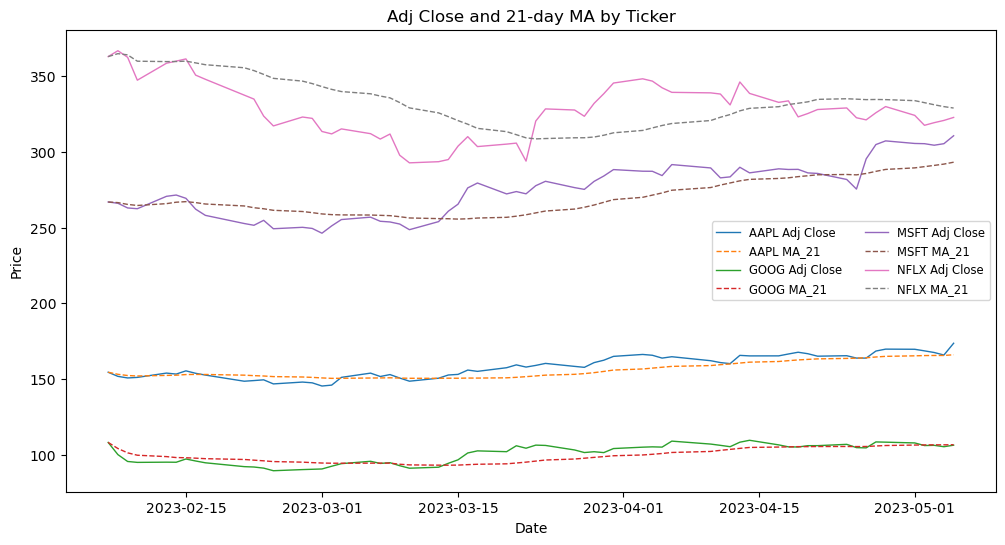

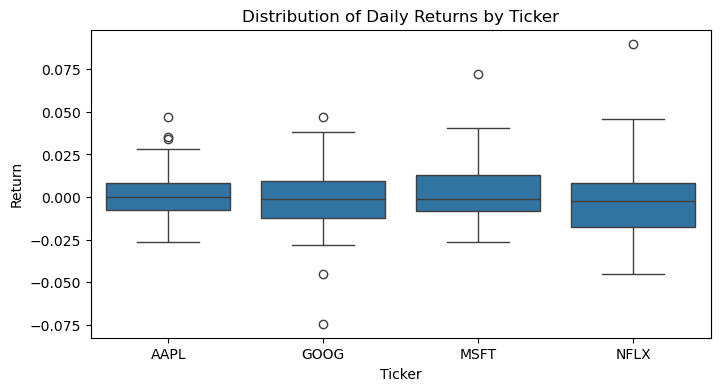

In [11]:
tickers = df['Ticker'].unique()
plt.figure(figsize=(12,6))
for t in tickers:
    sub = df[df['Ticker'] == t]
    plt.plot(sub['Date'], sub['Adj Close'], label=f'{t} Adj Close', linewidth=1)
    plt.plot(sub['Date'], sub['MA_21'], linestyle='--', label=f'{t} MA_21', linewidth=1)
plt.legend(ncol=2, fontsize='small')
plt.title('Adj Close and 21-day MA by Ticker')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x='Ticker', y='Return', data=df)
plt.title('Distribution of Daily Returns by Ticker')
plt.show()


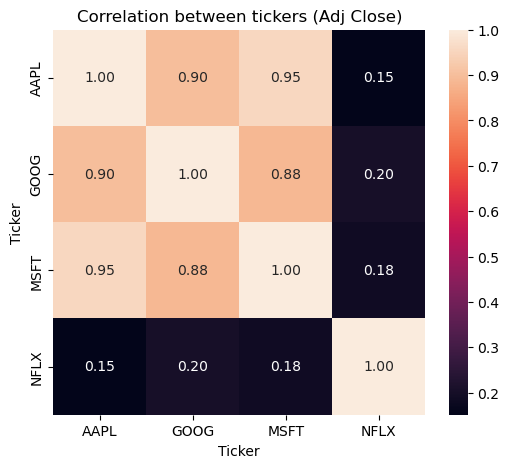

Pairwise correlations:
 Ticker      AAPL      GOOG      MSFT      NFLX
Ticker                                        
AAPL    1.000000  0.900405  0.953977  0.151178
GOOG    0.900405  1.000000  0.884590  0.201046
MSFT    0.953977  0.884590  1.000000  0.184535
NFLX    0.151178  0.201046  0.184535  1.000000


In [12]:
pivot = df.pivot(index='Date', columns='Ticker', values='Adj Close')
corr = pivot.corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title('Correlation between tickers (Adj Close)')
plt.show()
print("Pairwise correlations:\n", corr)


In [13]:

df['AdjClose_next'] = df.groupby('Ticker')['Adj Close'].shift(-1)
model_df = df.dropna(subset=['AdjClose_next']).copy()

features = ['Adj Close','MA_7','MA_21','Vol_7','Vol_21','Volume','Return']
X = model_df[features]
y = model_df['AdjClose_next']

cutoff = model_df['Date'].quantile(0.8)
train_mask = model_df['Date'] <= cutoff
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

print("Train rows:", X_train.shape[0], "Test rows:", X_test.shape[0])


Train rows: 196 Test rows: 48


In [14]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train.fillna(0), y_train)   

preds = rf.predict(X_test.fillna(0))
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print(f"Baseline RandomForest — RMSE: {rmse:.4f}, R2: {r2:.4f}")


Baseline RandomForest — RMSE: 5.7703, R2: 0.9959


Feature importances:
 Adj Close    0.379359
MA_7         0.317763
MA_21        0.299607
Volume       0.001398
Vol_21       0.001327
Return       0.000291
Vol_7        0.000255
dtype: float64


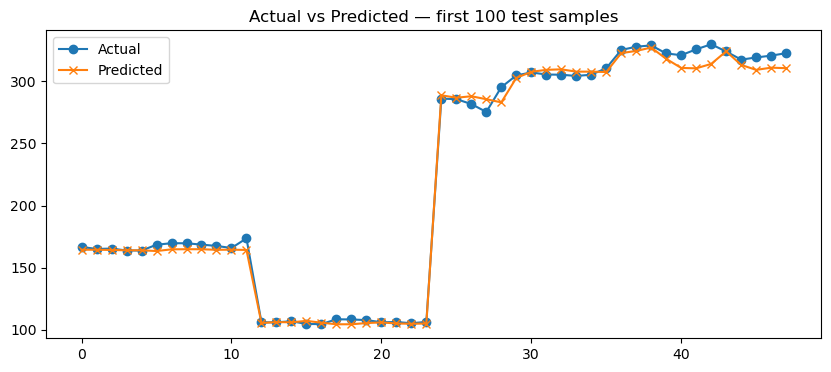

In [15]:
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
print("Feature importances:\n", importances)


plt.figure(figsize=(10,4))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(preds[:100], label='Predicted', marker='x')
plt.legend()
plt.title('Actual vs Predicted — first 100 test samples')
plt.show()


In [16]:
out_path = "stocks_cleaned_for_intern.csv"
df.to_csv(out_path, index=False)
print("Saved cleaned dataset to:", out_path)


Saved cleaned dataset to: stocks_cleaned_for_intern.csv
